
# Max Clique Problem



This tutorial solves the max clique problem in graph theory using Classiq.

A clique is a subset of vertices in a graph such that each pair is adjacent to one other. Given a graph $G = (V,E)$, find the maximal clique in the graph. It is known to be in the NP-hard complexity class.


## Defining the Optimization Problem

Encode each node as a binary variable:

In [1]:
import networkx as nx
import numpy as np
import pyomo.environ as pyo


def define_max_clique_model(graph):
    model = pyo.ConcreteModel()

    # each x_i states if node i belongs to the cliques
    model.x = pyo.Var(graph.nodes, domain=pyo.Binary)
    x_variables = np.array(list(model.x.values()))

    # define the complement adjacency matrix as the matrix where 1 exists for each non-existing edge
    adjacency_matrix = nx.convert_matrix.to_numpy_array(graph, nonedge=0)
    complement_adjacency_matrix = (
        1
        - nx.convert_matrix.to_numpy_array(graph, nonedge=0)
        - np.identity(len(model.x))
    )

    # constraint that 2 nodes without edge in the graph cannot be chosen together
    model.clique_constraint = pyo.Constraint(
        expr=x_variables @ complement_adjacency_matrix @ x_variables == 0
    )

    # maximize the number of nodes in the chosen clique
    model.value = pyo.Objective(expr=sum(x_variables), sense=pyo.maximize)

    return model

Initialize the model with parameters:

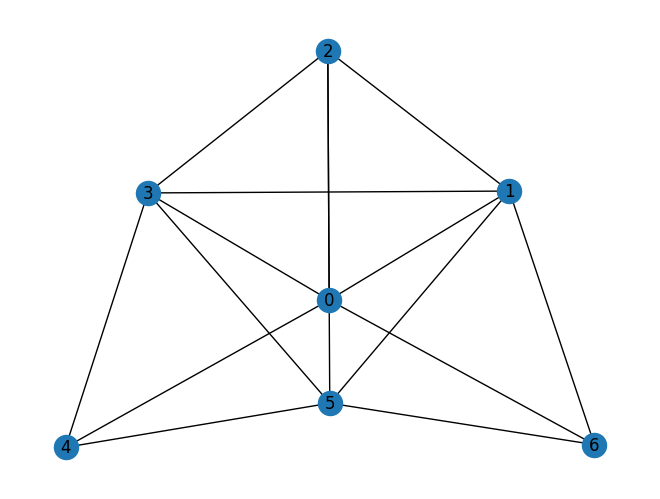

In [2]:
graph = nx.erdos_renyi_graph(7, 0.6, seed=79)
nx.draw_kamada_kawai(graph, with_labels=True)
max_clique_model = define_max_clique_model(graph)

## Setting Up the Classiq Problem Instance

To solve the Pyomo model defined above, use the `CombinatorialProblem` Python class. Under the hood, it translates the Pyomo model to a quantum model of the Quantum Approximate Optimization Algorithm (QAOA) [[1](#QAOA)], with a cost Hamiltonian translated from the Pyomo model. Choose the number of layers for the QAOA ansatz using the `num_layers` argument:

In [3]:
from classiq import *
from classiq.applications.combinatorial_optimization import CombinatorialProblem

combi = CombinatorialProblem(pyo_model=max_clique_model, num_layers=3)

qmod = combi.get_model()

In [4]:
write_qmod(qmod, "max_clique")

## Synthesizing the QAOA Circuit and Solving the Problem

Synthesize and view the QAOA circuit (ansatz) used to solve the optimization problem:

In [5]:
qprog = combi.get_qprog()
show(qprog)

Opening: https://nightly.platform.classiq.io/circuit/12b0d353-e44e-4992-bcb8-deb3a88a482b?version=0.62.0.dev7


Set the quantum backend on which to execute:

In [6]:
execution_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="simulator"),
)

Solve the problem by calling the `optimize` method of the `CombinatorialProblem` object. For the classical optimization part of the QAOA algorithm, define the maximum number of classical iterations (`maxiter`) and the $\alpha$-parameter (`quantile`) for running CVaR-QAOA, an improved variation of the QAOA algorithm [[2](#cvar)]:

In [7]:
optimized_params = combi.optimize(execution_preferences, maxiter=50, quantile=0.7)

Optimization Progress: 51it [02:27,  2.88s/it]                                         


Text(0.5, 1.0, 'Cost convergence')

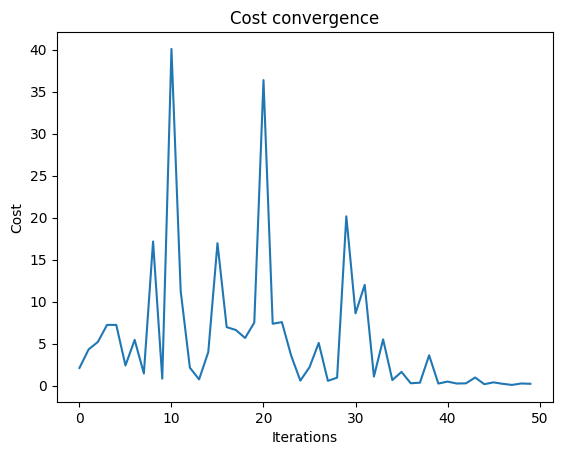

In [8]:
import matplotlib.pyplot as plt

plt.plot(combi.cost_trace)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost convergence")

## Viewing the Optimization Results

Examine the statistics of the algorithm. The optimization is always defined as a minimization problem, so the Pyomo-to-Qmod translator changes the positive maximization objective to negative minimization.

To get samples with the optimized parameters, call the `sample` method:

In [9]:
optimization_result = combi.sample(combi.optimized_params)
optimization_result.sort_values(by="cost").head(5)

,solution,probability,cost
93,"{'x': [0, 1, 1, 1, 0, 1, 0]}",0.000488,-4.0
86,"{'x': [1, 1, 1, 1, 0, 0, 0]}",0.000488,-4.0
50,"{'x': [0, 1, 1, 0, 0, 1, 0]}",0.003418,-3.0
41,"{'x': [1, 1, 0, 1, 0, 0, 0]}",0.004883,-3.0
44,"{'x': [1, 0, 1, 1, 0, 0, 0]}",0.004395,-3.0


Compare the optimized results to uniformly sampled results:

In [10]:
uniform_result = combi.sample_uniform()

And compare the histograms:

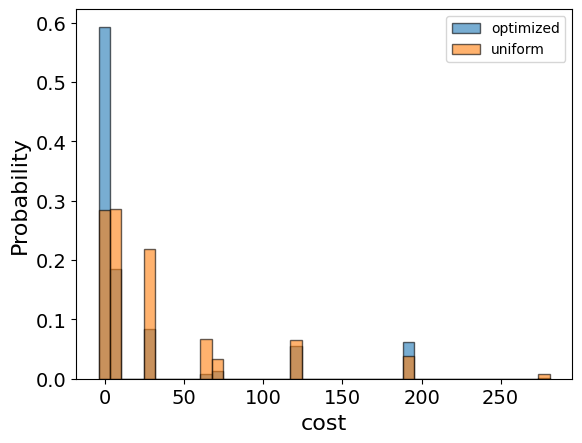

In [16]:
optimization_result["cost"].plot(
    kind="hist",
    bins=40,
    edgecolor="black",
    weights=optimization_result["probability"],
    alpha=0.6,
    label="optimized",
)
uniform_result["cost"].plot(
    kind="hist",
    bins=40,
    edgecolor="black",
    weights=uniform_result["probability"],
    alpha=0.6,
    label="uniform",
)
plt.legend()
plt.ylabel("Probability", fontsize=16)
plt.xlabel("cost", fontsize=16)
plt.tick_params(axis="both", labelsize=14)

Plot the solution:

In [12]:
best_solution = optimization_result.solution[optimization_result.cost.idxmin()]
best_solution

{'x': [1, 1, 1, 1, 0, 0, 0]}

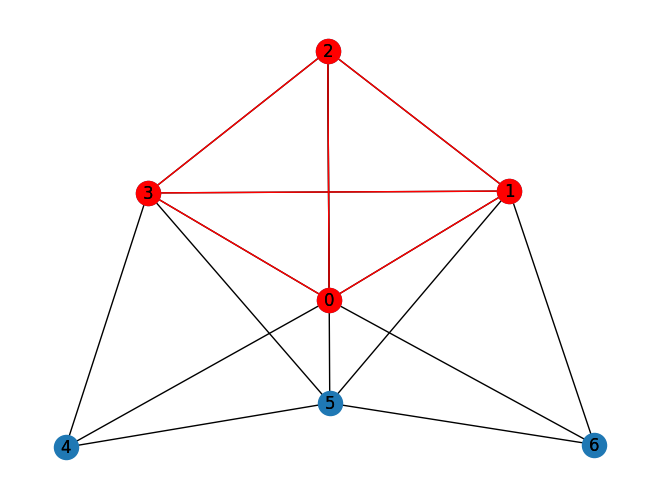

In [13]:
solution_nodes = [v for v in graph.nodes if best_solution["x"][v]]
solution_edges = [
    (u, v) for u, v in graph.edges if u in solution_nodes and v in solution_nodes
]
nx.draw_kamada_kawai(graph, with_labels=True)
nx.draw_kamada_kawai(
    graph,
    with_labels=True,
    nodelist=solution_nodes,
    edgelist=solution_edges,
    node_color="r",
    edge_color="r",
)

## Comparing to a Classical Solver

Lastly, compare to the classical solution of the problem:

In [14]:
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
solver.solve(max_clique_model)
classical_solution = [
    int(pyo.value(max_clique_model.x[i])) for i in range(len(max_clique_model.x))
]
print("Classical solution:", classical_solution)

Classical solution: [1, 1, 1, 1, 0, 0, 0]


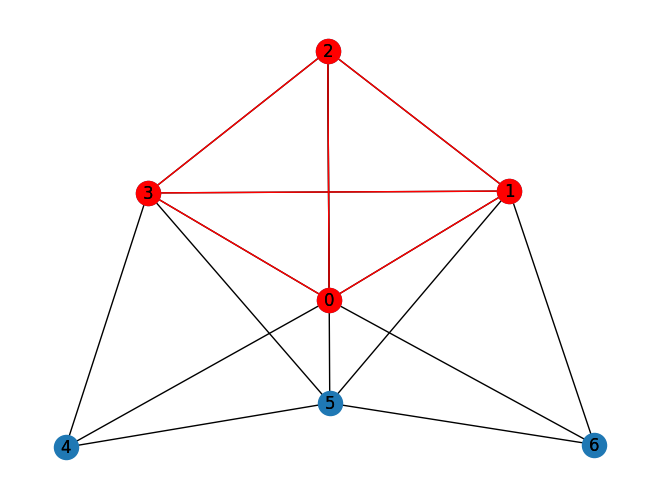

In [15]:
solution = [int(pyo.value(max_clique_model.x[i])) for i in graph.nodes]
solution_nodes = [v for v in graph.nodes if solution[v]]
solution_edges = [
    (u, v) for u, v in graph.edges if u in solution_nodes and v in solution_nodes
]
nx.draw_kamada_kawai(graph, with_labels=True)
nx.draw_kamada_kawai(
    graph,
    with_labels=True,
    nodelist=solution_nodes,
    edgelist=solution_edges,
    node_color="r",
    edge_color="r",
)

## References

<a id='QAOA'>[1]</a> [Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. (2014). A quantum approximate optimization algorithm. arXiv preprint arXiv:1411.4028.](https://arxiv.org/abs/1411.4028)

<a id='cvar'>[2]</a> [Barkoutsos, Panagiotis Kl, et al. (2020). Improving variational quantum optimization using CVaR. Quantum 4: 256.](https://arxiv.org/abs/1907.04769)
